# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import udf , desc, asc, countDistinct, avg, col, to_date, to_timestamp, from_unixtime, desc, datediff
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName('Data_Sci_Capstone')\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Read in json file
mini_sparkify = spark.read.json('mini_sparkify_event_data.json')

In [4]:
#Review file schema (column labels)
mini_sparkify.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
mini_sparkify.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
mini_sparkify.count()

286500

In [7]:
#Check for missing data in userId and sessionId labels
mini_valid = mini_sparkify.dropna(how='all', subset=['userId', 'sessionId'])

In [8]:
#Identify invalid userId inputs
mini_valid.groupby('level').agg(countDistinct('userId')).show()


+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   196|
| paid|                   166|
+-----+----------------------+



In [9]:
#Drop invalid userId inputs from dataset
mini_valid=mini_valid.filter(mini_valid['userId'] != '')
mini_valid.count()

278154

In [10]:
#Identify invalid sessionId inputs
mini_valid.describe('itemInSession').show()
mini_valid.groupBy('itemInSession').count().orderBy(col('count').desc()).show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            2| 2941|
|            3| 2917|
|            4| 2887|
|            5| 2836|
|            1| 2818|
|            6| 2803|
|            7| 2776|
|            8| 2735|
|            9| 2693|
|            0| 2689|
|           10| 2633|
|           11| 2596|
|           12| 2556|
|           13| 2513|
|           14| 2485|
|           15| 2456|
|           16| 2428|
|           17| 2385|
|           18| 2345|
|           19| 2322|
+-------------+-----+
only showing top 20 rows



In [11]:
#View artist label description
mini_valid.groupBy('page').agg(countDistinct('artist')).show()

+--------------------+----------------------+
|                page|count(DISTINCT artist)|
+--------------------+----------------------+
|              Cancel|                     0|
|    Submit Downgrade|                     0|
|         Thumbs Down|                     0|
|                Home|                     0|
|           Downgrade|                     0|
|         Roll Advert|                     0|
|              Logout|                     0|
|       Save Settings|                     0|
|Cancellation Conf...|                     0|
|               About|                     0|
|            Settings|                     0|
|     Add to Playlist|                     0|
|          Add Friend|                     0|
|            NextSong|                 17655|
|           Thumbs Up|                     0|
|                Help|                     0|
|             Upgrade|                     0|
|               Error|                     0|
|      Submit Upgrade|            

In [12]:
mini_valid.select('level','auth').dropDuplicates().show()

+-----+---------+
|level|     auth|
+-----+---------+
| paid|Cancelled|
| free|Logged In|
| free|Cancelled|
| paid|Logged In|
+-----+---------+



In [13]:
mini_valid.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [14]:
mini_valid.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
#set up function to identify cancellation/churn event
flag_churn = udf(lambda page: int((page == 'Cancellation Confirmation') ), IntegerType())

In [16]:
# add churn column to dataset to flag a cancellation event
mini_valid= mini_valid.withColumn('churn', flag_churn('page'))

In [17]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [18]:
# add phase column to identify churn vs no-churn users
mini_valid=mini_valid.withColumn('phase', Fsum('churn').over(windowval))

In [19]:
#the number of churn users in the dataset compared to no_churn users
mini_valid.select('userId', 'phase')\
            .groupby('phase')\
            .agg(countDistinct('userId')).show()

+-----+----------------------+
|phase|count(DISTINCT userId)|
+-----+----------------------+
|    0|                   173|
|    1|                    52|
+-----+----------------------+



In [20]:
#count of churn users by level in dataset
mini_valid.filter(mini_valid.phase ==1)\
            .select('userId', 'level')\
            .groupby('level')\
            .agg(countDistinct('userId')).show()

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                    46|
| paid|                    36|
+-----+----------------------+



### The stats above indicate that there is some overlap between free and paid users.  To investigate further, let's look at the number of downgrades (from paid to free) in the churn group

In [21]:
#Downgrades in churn group
mini_valid.filter(mini_valid.phase ==1)\
            .filter(mini_valid.page == 'Downgrade')\
            .groupby( 'page')\
            .agg(countDistinct('userId')).show()

+---------+----------------------+
|     page|count(DISTINCT userId)|
+---------+----------------------+
|Downgrade|                    35|
+---------+----------------------+



In [22]:
#Downgrades in no churn group
mini_valid.filter(mini_valid.phase ==0)\
            .filter(mini_valid.page == 'Downgrade')\
            .groupby( 'page')\
            .agg(countDistinct('userId')).show()

+---------+----------------------+
|     page|count(DISTINCT userId)|
+---------+----------------------+
|Downgrade|                   119|
+---------+----------------------+



### Other features of churn group

In [23]:
#count of churn users by level in dataset
mini_valid.filter(mini_valid.phase ==1)\
            .select('userId', 'gender')\
            .groupby( 'gender')\
            .agg(countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                    20|
|     M|                    32|
+------+----------------------+



In [24]:
#count of no_churn users level in dataset
mini_valid.filter(mini_valid.phase ==0)\
            .select('userId', 'level')\
            .groupby('level')\
            .agg(countDistinct('userId')).show()

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   149|
| paid|                   129|
+-----+----------------------+



In [25]:
#count of no_churn users by level in dataset
mini_valid.filter(mini_valid.phase ==0)\
            .select('userId', 'gender')\
            .groupby( 'gender')\
            .agg(countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                    84|
|     M|                    89|
+------+----------------------+



## Create datetime categories to run analysis

In [26]:
#Convert timestamp to datetime date
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))

In [27]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [28]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)

In [29]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)

In [30]:
mini_valid = mini_valid.withColumn('hour', get_hour('ts').cast(IntegerType()))\
            .withColumn('day', get_day('ts').cast(IntegerType()))\
            .withColumn('month', get_month('ts').cast(IntegerType()))\
            .withColumn('date', get_date('ts').cast(DateType()))

In [31]:
mini_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- phase: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: date (nullable = true)



In [32]:
mini_valid.select('month').dropDuplicates().orderBy(mini_valid.month).show()

+-----+
|month|
+-----+
|   10|
|   11|
|   12|
+-----+



## Churn Analysis 

In [33]:
#dataset of churn users
churn_pop=mini_valid.filter(mini_valid.phase == 1)\
            .select('userId', 'level','page', 'churn', 'phase', 'ts','date' ,'day','hour','month', 'itemInSession')

In [34]:
#dataset of no_churn users
no_churn_pop=mini_valid.filter(mini_valid.phase == 0)\
            .select('userId', 'level','page', 'churn', 'phase','ts', 'date', 'day','hour','month','itemInSession')

In [35]:
#Calculate the average number of songs listened to before churn per user
songs_per_churnUser= churn_pop.filter(churn_pop.page == 'NextSong')\
                    .select('userId', 'level', 'page')\
                    .groupBy('userId')\
                    .agg({'page':'count'})\
                    .agg({'count(page)': 'avg'}).show()


+-----------------+
| avg(count(page))|
+-----------------+
|699.8846153846154|
+-----------------+



In [36]:
#Calculate the average number of songs listened to per no_churn user
songs_per_user= no_churn_pop.filter(churn_pop.page == 'NextSong')\
                    .select('userId', 'level', 'page')\
                    .groupBy('userId')\
                    .agg({'page':'count'})\
                    .agg({'count(page)': 'avg'}).show()


+------------------+
|  avg(count(page))|
+------------------+
|1108.1734104046243|
+------------------+



## Graph of total songs Played per hour for churn vs no-churn users

In [37]:
songs_per_churnHour = churn_pop.filter(churn_pop.page =='NextSong')\
                        .groupBy(churn_pop.hour)\
                        .count()\
                        .orderBy(churn_pop.hour)

In [38]:
songs_per_no_churnHour = no_churn_pop.filter(no_churn_pop.page =='NextSong')\
                        .groupBy('hour')\
                        .count()\
                        .orderBy(no_churn_pop.hour)

In [39]:
#Preparing the dataset for plotting
songs_churnHour_df = songs_per_churnHour.toPandas()
songs_no_churnHour_df = songs_per_no_churnHour.toPandas()

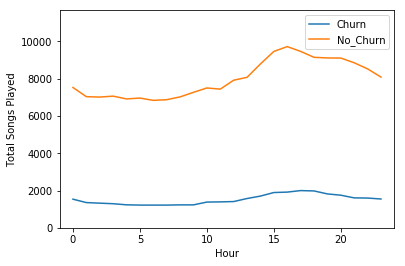

In [40]:
hours = songs_churnHour_df.hour
no_churn_songs = songs_no_churnHour_df['count']
churn_songs =songs_churnHour_df['count']

plt.plot(hours, churn_songs),#Churn group represented by line
plt.plot(hours, no_churn_songs) #No churn group represented by scatter plot
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(no_churn_songs))
plt.xlabel("Hour")
plt.ylabel("Total Songs Played")
plt.legend(['Churn', 'No_Churn']);

## Average songs Played per user per hour for churn vs no churn users

In [41]:
#Calculate the average number of songs per user per hour for churn
avg_songs_churnUser= churn_pop.filter(churn_pop.page == 'NextSong')\
                    .select('userId','date',  'hour', 'page')\
                    .groupBy('userId', 'date', 'hour')\
                    .agg({'page':'count'})\
                    .groupBy('userId','hour')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('hour')\
                    .agg({'avg(count(page))': 'avg'})\
                    .orderBy('hour')
                    
                    

In [42]:
avg_songs_churnUser.show(2)

+----+---------------------+
|hour|avg(avg(count(page)))|
+----+---------------------+
|   0|   10.735912698412697|
|   1|   10.816071428571432|
+----+---------------------+
only showing top 2 rows



In [44]:
#Calculate the average number of songs per user per hour for no churn users
avg_songs_no_churnUser= no_churn_pop.filter(no_churn_pop.page == 'NextSong')\
                    .select('userId','date',  'hour', 'page')\
                    .groupBy('userId', 'date', 'hour')\
                    .agg({'page':'count'})\
                    .groupBy('userId','hour')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('hour')\
                    .agg({'avg(count(page))': 'avg'})\
                    .orderBy('hour')
                    
                    

In [46]:
avg_songs_no_churnUser.show(2)

+----+---------------------+
|hour|avg(avg(count(page)))|
+----+---------------------+
|   0|   12.437618403494312|
|   1|    12.08318004459309|
+----+---------------------+
only showing top 2 rows



In [47]:
#Prepping dataset for plotting
avg_songs_churnUser_df = avg_songs_churnUser.toPandas()
avg_songs_churnUser_df.columns = ['hour', 'num_songs']
avg_songs_no_churnUser_df = avg_songs_no_churnUser.toPandas()
avg_songs_no_churnUser_df.columns = ['hour', 'num_songs']

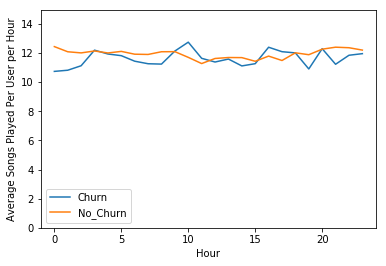

In [48]:
avg_hours = avg_songs_churnUser_df.hour
avg_no_churn_songs = avg_songs_no_churnUser_df['num_songs']
avg_churn_songs =avg_songs_churnUser_df['num_songs']

plt.plot(avg_hours, avg_churn_songs),#Churn group represented by line
plt.plot(avg_hours, avg_no_churn_songs) #No churn group represented by scatter plot
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(avg_no_churn_songs))
plt.xlabel("Hour")
plt.ylabel("Average Songs Played Per User per Hour")
plt.legend(['Churn', 'No_Churn']);

## Graph of  Average Number of Songs Played per Day for churn vs no_churn groups

In [49]:
#Calculate the average number of songs per user per day for no churn users
day_songs_churnUser= churn_pop.filter(churn_pop.page == 'NextSong')\
                    .select('userId', 'date','day', 'page')\
                    .groupBy('date','day', 'userId')\
                    .agg({'page':'count'})\
                    .groupBy('day', 'userId')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('day')\
                    .agg({'avg(count(page))': 'avg'})\
                    .orderBy('day')


In [50]:
#Calculate the average number of songs per user per day for no churn users
day_songs_no_churnUser= no_churn_pop.filter(no_churn_pop.page == 'NextSong')\
                    .select('userId', 'date','day', 'page')\
                    .groupBy('date','day', 'userId')\
                    .agg({'page':'count'})\
                    .groupBy('day', 'userId')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('day')\
                    .agg({'avg(count(page))': 'avg'})\
                    .orderBy('day')

In [51]:
day_songs_churnUser.show(2)

+---+---------------------+
|day|avg(avg(count(page)))|
+---+---------------------+
|  1|    56.47727272727273|
|  2|    69.35416666666667|
+---+---------------------+
only showing top 2 rows



In [52]:
day_songs_no_churnUser.show(2)

+---+---------------------+
|day|avg(avg(count(page)))|
+---+---------------------+
|  1|    72.28270042194093|
|  2|    80.66197183098592|
+---+---------------------+
only showing top 2 rows



In [53]:
#Prepping dataset for plotting
day_songs_churnUser_df = day_songs_churnUser.toPandas()
day_songs_churnUser_df.columns= ['day', 'songs_per_day']
day_songs_no_churnUser_df = day_songs_no_churnUser.toPandas()
day_songs_no_churnUser_df.columns= ['day', 'songs_per_day']

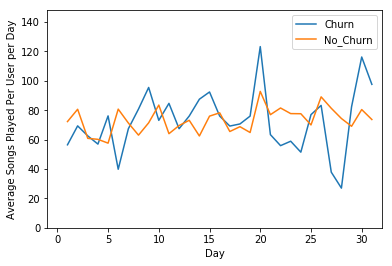

In [54]:
days = day_songs_churnUser_df.day
day_no_churn_songs = day_songs_no_churnUser_df['songs_per_day']
day_churn_songs =day_songs_churnUser_df['songs_per_day']

plt.plot(days, day_churn_songs),#Churn group represented by line
plt.plot(days, day_no_churn_songs) #No churn group represented by scatter plot
plt.xlim(-1, 32);
plt.ylim(0, 1.2 * max(day_churn_songs))
plt.xlabel("Day")
plt.ylabel("Average Songs Played Per User per Day")
plt.legend(['Churn', 'No_Churn']);

## Number of Cancellations per Day in a Month

In [55]:
cancel_day =churn_pop.filter(churn_pop.churn==1)\
            .select('userId','hour','day', 'month')\
            .groupBy('day')\
            .agg({'day':'count'})\
            .orderBy(churn_pop.day)

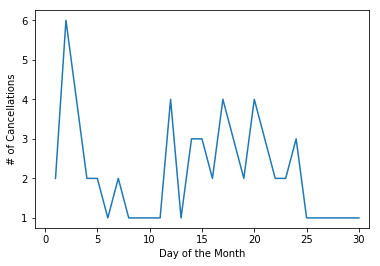

In [56]:
cancel_day_df =cancel_day.toPandas()

plt.plot(cancel_day_df.day, cancel_day_df['count(day)'])
plt.xlim(-1,31)
plt.xlabel('Day of the Month')
plt.ylabel('# of Cancellations');

## Cancellations for a given hour

In [57]:
cancel_hour =churn_pop.filter(churn_pop.churn==1)\
            .select('userId','hour','day', 'month')\
            .groupBy('hour')\
            .agg({'hour':'count'})\
            .orderBy(churn_pop.hour)

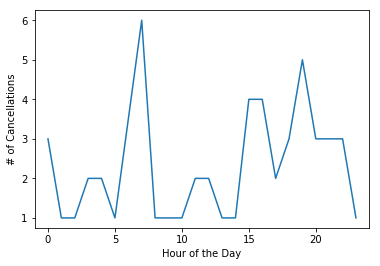

In [58]:
cancel_hour_df =cancel_hour.toPandas()
plt.plot(cancel_hour_df.hour, cancel_hour_df['count(hour)'])
plt.xlim(-1,24)
plt.xlabel('Hour of the Day')
plt.ylabel('# of Cancellations');

## Number of cancellations per month

In [59]:
cancel_month =churn_pop.filter(churn_pop.churn==1)\
            .select('userId','hour','day', 'month')\
            .groupBy('month')\
            .agg({'month':'count'})\
            .orderBy(churn_pop.month)

cancel_month.show()

+-----+------------+
|month|count(month)|
+-----+------------+
|   10|          30|
|   11|          22|
+-----+------------+



## Number of days between 1st song played and cancellation (churn users)

In [60]:
#Determine users first date in Sparkify (equal to last timestamp in system)
min_churn_ts=churn_pop.select('userId', 'ts')\
            .groupBy('userId')\
            .min('ts')

#Determine users last date in Sparkify (equal to last timestamp in system)
max_churn_ts=churn_pop.select('userId', 'ts')\
            .groupBy('userId')\
            .max('ts')


In [61]:
#Calculate the difference between first and last dates in Sparkify
min_churn_ts=min_churn_ts.withColumn('startDate', get_date('min(ts)'))
churn_ts=min_churn_ts.join(max_churn_ts, max_churn_ts.userId ==min_churn_ts.userId)
churn_ts=churn_ts.withColumn('lastDate', get_date('max(ts)'))\
                    .withColumn('daysInSparkify', datediff(col('lastDate'),col('startDate')))


## Number of days between 1st song played and last song played (no_churn users)

In [62]:
#Determine users first date in Sparkify (equal to first timestamp in system)
min_no_churn_ts=no_churn_pop.select('userId', 'ts')\
            .groupBy('userId')\
            .min('ts')

#Determine users last date in Sparkify (equal to last timestamp in system)
max_no_churn_ts=no_churn_pop.select('userId', 'ts')\
            .groupBy('userId')\
            .max('ts')


In [63]:
#Calculate the difference between first and last dates in Sparkify
min_no_churn_ts=min_no_churn_ts.withColumn('startDate', get_date('min(ts)'))
no_churn_ts=min_no_churn_ts.join(max_no_churn_ts, max_no_churn_ts.userId ==min_no_churn_ts.userId)
no_churn_ts=no_churn_ts.withColumn('lastDate', get_date('max(ts)'))\
                    .withColumn('daysInSparkify', datediff(col('lastDate'),col('startDate')))


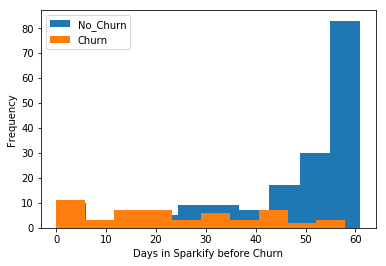

In [64]:
#plot the number of days churn users are in the Sparkify app
churn_ts_df=churn_ts.toPandas()
no_churn_ts_df= no_churn_ts.toPandas()

plt.hist(no_churn_ts_df['daysInSparkify']),
plt.hist(churn_ts_df['daysInSparkify'])

plt.xlabel('Days in Sparkify before Churn')
plt.ylabel('Frequency')
plt.legend(['No_Churn', 'Churn']);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Initial Base Model dataset

I want to use gender as a feature in our model so we will use StringIndexer to encode the binary variables.  Female = 0, Male =1

In [65]:
from pyspark.ml.feature import StringIndexer

In [66]:
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_encoded")
gen_indexed = gender_indexer.fit(mini_valid).transform(mini_valid)
gen_indexed.show(3)

+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-----------+------+-------------+--------------------+------+-----+-----+----+---+-----+----------+--------------+
|    artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|       song|status|           ts|           userAgent|userId|churn|phase|hour|day|month|      date|gender_encoded|
+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-----------+------+-------------+--------------------+------+-----+-----+----+---+-----+----------+--------------+
|      null|Logged In| Darianna|     F|           34|Carpenter|     null| free|Bridgeport-Stamfo...|   PUT|  Logout|1538016340000|      187|       null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|    0|    0|  18| 21|   11|2018-11

In [67]:
model_df = gen_indexed.groupBy('userId').agg({'song':'count','phase':'avg', 'gender_encoded':'avg','length':'avg' })

## Add total days in Sparkify (daysInSparkify) as a column to the model dataset

In [68]:
#Total days for each user in the churn group
days_in_Sparkify_churn = churn_ts.toPandas()

In [69]:
#Rename columns and delete redundant columns
days_in_Sparkify_churn.columns= ['userId', 'min_ts','startDate', 'falseCat', 'max_ts', 'lastDate', 'daysInSparkify']
del days_in_Sparkify_churn['falseCat']

In [70]:
#Total days for each user in the no_churn group
days_in_Sparkify_no_churn = no_churn_ts.toPandas()

In [71]:
#Rename columns and delete redundant columns
days_in_Sparkify_no_churn.columns= ['userId', 'min_ts','startDate', 'falseCat', 'max_ts', 'lastDate', 'daysInSparkify']
del days_in_Sparkify_no_churn['falseCat']

In [72]:
#Combine the count of daysInSparkify dataframes for churn and no_churn users
sparky_days =days_in_Sparkify_no_churn.append(days_in_Sparkify_churn)

In [73]:
#Only keep relevant columns to append to the model dataset
sparky_days = sparky_days[['userId','daysInSparkify']]
sparky_days.head()

,userId,daysInSparkify
0,100010,44
1,200002,45
2,124,60
3,7,51
4,15,55


## Join daysInSparkify to model_df (once converted to a pandas df)

In [74]:
#Convert the odel dataframe (model_df) to a pandas dataframe to facilitate adding additonal relevant columns
model_df_pd=model_df.toPandas()

In [75]:
#Merge the model dataset to include the number of days a user has been part Sparkify
model_df_pd=model_df_pd.merge(sparky_days, on= 'userId')

In [76]:
model_df_pd.head()

,userId,count(song),avg(phase),avg(length),avg(gender_encoded),daysInSparkify
0,100010,275,0.0,243.421445,0.0,44
1,200002,387,0.0,242.916992,1.0,45
2,125,8,1.0,261.139138,1.0,0
3,124,4079,0.0,248.176537,0.0,60
4,51,2111,1.0,247.880551,1.0,16


In [77]:
#Rename columns for clarity
model_df_pd.columns = ['userId', 'total_song_count', 'phase', 'avg_length', 'gender','daysInSparkify' ]

In [78]:
model_df_pd.head()

,userId,total_song_count,phase,avg_length,gender,daysInSparkify
0,100010,275,0.0,243.421445,0.0,44
1,200002,387,0.0,242.916992,1.0,45
2,125,8,1.0,261.139138,1.0,0
3,124,4079,0.0,248.176537,0.0,60
4,51,2111,1.0,247.880551,1.0,16


## Add average songs played per day per user as a column to the model dataset

In [79]:
#Avg daily songs played each user in the churn group
avg_daily_songs = mini_valid.filter(mini_valid.page == 'NextSong')\
                    .select('userId', 'date','day', 'page')\
                    .groupBy('userId','date','day')\
                    .agg({'page':'count'})\
                    .groupBy('userId', 'day')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('userId')\
                    .agg({'avg(count(page))': 'avg'}).toPandas()

In [80]:
avg_daily_songs.head()

,userId,avg(avg(count(page)))
0,100010,39.285714
1,200002,55.285714
2,125,8.000000
3,124,134.980000
4,51,162.384615


In [81]:
avg_daily_songs.columns = ['userId', 'avg_daily_songs']
avg_daily_songs.head()

,userId,avg_daily_songs
0,100010,39.285714
1,200002,55.285714
2,125,8.000000
3,124,134.980000
4,51,162.384615


In [82]:
#Add column for average daily songs played by each user
model_df_pd= model_df_pd.merge(avg_daily_songs, on='userId')


In [83]:
#Add column that calculates per day user song count based on the number of days in Sparkify
model_df_pd['songs_per_day'] = model_df_pd.total_song_count/(model_df_pd.daysInSparkify+1)


In [84]:
model_df_pd.head()

,userId,total_song_count,phase,avg_length,gender,daysInSparkify,avg_daily_songs,songs_per_day
0,100010,275,0.0,243.421445,0.0,44,39.285714,6.111111
1,200002,387,0.0,242.916992,1.0,45,55.285714,8.413043
2,125,8,1.0,261.139138,1.0,0,8.000000,8.000000
3,124,4079,0.0,248.176537,0.0,60,134.980000,66.868852
4,51,2111,1.0,247.880551,1.0,16,162.384615,124.176471


## Average songs viewed per hour per user

In [85]:
#Determine the average number of songs played per hour for each user
songs_per_hour =mini_valid.filter(mini_valid.page == 'NextSong')\
                    .select('userId','date',  'hour', 'page')\
                    .groupBy('userId', 'date', 'hour')\
                    .agg({'page':'count'})\
                    .groupBy('userId','hour')\
                    .agg({'count(page)':'avg'})\
                    .groupBy('userId')\
                    .agg({'avg(count(page))': 'avg'})\
                    .orderBy('userId')\
                    .toPandas()

In [86]:
#Rename columns for clarity
songs_per_hour.columns= ['userId', 'songs_per_hour']
songs_per_hour.head()

,userId,songs_per_hour
0,10,13.368056
1,100,12.401480
2,100001,9.583333
3,100002,11.769231
4,100003,10.875000


In [87]:
#Merge the model dataset to include the average number of songs a user listened to per hour
model_df_pd=model_df_pd.merge(songs_per_hour, on= 'userId')

In [88]:
#set the model dataset index to userId
#model_df_pd.set_index('userId')
model_df_pd.head()

,userId,total_song_count,phase,avg_length,gender,daysInSparkify,avg_daily_songs,songs_per_day,songs_per_hour
0,100010,275,0.0,243.421445,0.0,44,39.285714,6.111111,10.313725
1,200002,387,0.0,242.916992,1.0,45,55.285714,8.413043,12.175439
2,125,8,1.0,261.139138,1.0,0,8.000000,8.000000,8.000000
3,124,4079,0.0,248.176537,0.0,60,134.980000,66.868852,13.431330
4,51,2111,1.0,247.880551,1.0,16,162.384615,124.176471,13.483829


##  Convert dataset back to spark dataframe and normalize the dataset

In [89]:
new_df =spark.createDataFrame(model_df_pd)

In [90]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler

In [91]:

assembler = VectorAssembler(inputCols= ['total_song_count','avg_length','gender','daysInSparkify','avg_daily_songs','songs_per_day','songs_per_hour'], outputCol='features')
new_df= assembler.transform(new_df)

In [92]:
scaler = Normalizer(inputCol= 'features', outputCol='scaled_features')
new_df = scaler.transform(new_df)

In [93]:
std_scaler = StandardScaler(inputCol = 'features', outputCol = 'std_scale_features')
new_scaler= std_scaler.fit(new_df)
new_df= new_scaler.transform(new_df)

In [94]:
new_df.show(1)

+------+----------------+-----+----------------+------+--------------+------------------+-----------------+------------------+--------------------+--------------------+--------------------+
|userId|total_song_count|phase|      avg_length|gender|daysInSparkify|   avg_daily_songs|    songs_per_day|    songs_per_hour|            features|     scaled_features|  std_scale_features|
+------+----------------+-----+----------------+------+--------------+------------------+-----------------+------------------+--------------------+--------------------+--------------------+
|100010|             275|  0.0|243.421444909091|   0.0|            44|39.285714285714285|6.111111111111111|10.313725490196077|[275.0,243.421444...|[0.73893210637414...|[0.24887761207221...|
+------+----------------+-----+----------------+------+--------------+------------------+-----------------+------------------+--------------------+--------------------+--------------------+
only showing top 1 row



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [95]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [96]:
# Select phase as the target column and use the scaled_features vector
data = new_df.select(col('phase').alias('label'), col('scaled_features').alias('features'))
data.head()

Row(label=0.0, features=DenseVector([0.7389, 0.6541, 0.0, 0.1182, 0.1056, 0.0164, 0.0277]))

In [97]:
#Split data into training, test and validation
training_df, test_df, validation_df = data.randomSplit([.6, .2,.2], 42)

## Running a Logistic Regression Model

In [98]:
logr= LogisticRegression(maxIter=15)

In [99]:
#Train Logistic Regression Model
train_model = logr.fit(training_df)

### Testing model accuracy

In [100]:
modelSummary= train_model.summary

In [101]:
modelSummary.accuracy

0.8226950354609929

In [102]:
modelSummary.precisionByLabel

[0.832, 0.75]

In [103]:
modelSummary.fMeasureByLabel()

[0.8927038626609441, 0.48979591836734687]

## Running a DecisionTree Classifier Model

In [104]:
#Train Decision Tree Model
dtc= DecisionTreeClassifier(labelCol= 'label', featuresCol='features')

In [105]:
model =dtc.fit(training_df)

In [106]:
#Run predictions on test data
predictions = model.transform(test_df)

In [107]:
predictions.show(1)

+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|  0.0|[0.01300748108887...|   [65.0,2.0]|[0.97014925373134...|       0.0|
+-----+--------------------+-------------+--------------------+----------+
only showing top 1 row



In [109]:
#Evaluate model for accuracy on test data
evaluator = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy') # taken from pyspark documentation

In [110]:
accuracy = evaluator.evaluate(predictions)
accuracy

0.8461538461538461

In [111]:
#Evaluate model for accuracy on validation data
preds_validation = model.transform(validation_df)

In [112]:
evaluator2 = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='preds_prediction', metricName='accuracy')

In [113]:
accuracy2 = evaluator.evaluate(preds_validation)
accuracy2

0.6875

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.